In [5]:
# Import libraries
%matplotlib inline
import matplotlib.pyplot as plt
import time
import numpy as np
from numpy import random
import math
import scipy
from scipy import stats
from random import choice
import networkx as nx
import json
from networkx.readwrite import json_graph

In [6]:
import findspark
import os
findspark.init()
import pyspark
sc = pyspark.SparkContext()

In [7]:
# Load network graph
with open("graph/nc_mini.json", "r") as graph_data_mini:
    graph_data_mini = json.load(graph_data_mini)
    NC_digraph_mini = json_graph.node_link_graph(graph_data_mini)
    
with open("graph/nc_full.json", "r") as graph_data_full:
    graph_data_full = json.load(graph_data_full)
    NC_digraph_full = json_graph.node_link_graph(graph_data_full)

In [8]:
def influenceFunction(graph, detStartNodes, t=999999):

    explored = set()
    activated = set()
    nodes = []
    for node in detStartNodes:
        nodes.append(node)
        activated.add(node)
    
    start = detStartNodes[0]
    successors = []

    for i in range(t):
        successors = []
        while len(nodes)>0:
            startNode = nodes[0]
            if startNode not in explored:
                explored.add(startNode)
            for succNode in graph.succ[startNode]:
                if succNode not in activated:
                    alpha = graph[startNode][succNode]['weight']
                    beta = graph.node[succNode]['review_count']
                    if random.uniform(0,1) < np.sqrt(random.beta(alpha, beta)):
                        if succNode not in explored:
                            activated.add(succNode)
                            successors.append(succNode)
            nodes.remove(startNode)
        nodes = successors
        if not nodes:
            break
    return float(len(activated))

In [9]:
def influenceFunctionNotParDetStart(graph, detStartNodes, N, t=999999):
    result = []
    for n in xrange(N):
        result.append(float(influenceFunction(graph, detStartNodes, t)))
    return np.mean(result)

In [10]:
def influenceFunctionParDetStart(graph, detStartNodes, N, t=999999):
    runs = sc.parallelize(range(N), 4)
    results = runs.map(lambda x: influenceFunction(graph, detStartNodes, t))
    return np.mean(results.collect())

In [11]:
def influenceFunctionNotParRandStart(graph, N, t=999999):
    result = []
    for n in xrange(N):
        result.append(float(influenceFunction(graph, [random.choice(graph.nodes(),1)[0]], t)))
    return np.mean(result)

In [12]:
def influenceFunctionParRandStart(graph, N, t=999999):
    runs = sc.parallelize(range(N), 4)
    results = runs.map(lambda x: influenceFunction(graph, [random.choice(graph.nodes(),1)[0]], t))
    return np.mean(results.collect())

In [13]:
def greedySearch(graph, k=3, N=1000, t=999999):
    
    best_s = []
    max_inf = 0
    nodeRDD = sc.parallelize(list(set(list(sum(graph.edges(), ())))), 4)
    
    for i in range(k):
        infRDD = nodeRDD.map(lambda n: (n, 0.) if n in best_s else \
                             (n, influenceFunctionNotParDetStart(graph, best_s + [n], N)))
        next_s, next_i = infRDD.reduce(lambda a,b: a if a[1] > b[1] else b)
#         print next_s
        best_s += [next_s]
        max_inf = next_i
    
    return best_s, max_inf

In [32]:
k = 100

startTime = time.time()

results = []
for i in xrange(100):
    if i%10==0:
        runTime = time.time() - startTime
        print '%d of 100 iterations, %f seconds total run time' % (i, runTime)
    results.append(influenceFunctionParRandStart(NC_digraph_full, k))
fd = open("data/SE-NC_full-N=" + str(k) + ".json","w")
json.dump(results, fd)
fd.close()
del results

runTime = time.time() - startTime
print '%f seconds total run time' % (runTime)

0 of 100 iterations, 0.000237 seconds total run time
10 of 100 iterations, 64.502450 seconds total run time
20 of 100 iterations, 129.584046 seconds total run time
30 of 100 iterations, 194.239050 seconds total run time
40 of 100 iterations, 258.043409 seconds total run time
50 of 100 iterations, 322.082560 seconds total run time
60 of 100 iterations, 386.923489 seconds total run time
70 of 100 iterations, 451.975057 seconds total run time
80 of 100 iterations, 518.075152 seconds total run time
90 of 100 iterations, 586.032910 seconds total run time
652.515220 seconds total run time


In [17]:
k = 250

startTime = time.time()

results = []
for i in xrange(100):
    if i%10==0:
        runTime = time.time() - startTime
        print '%d of 100 iterations, %f seconds total run time' % (i, runTime)
    results.append(influenceFunctionParRandStart(NC_digraph_full, k))
fd = open("data/SE-NC_full-N=" + str(k) + ".json","w")
json.dump(results, fd)
fd.close()
del results

runTime = time.time() - startTime
print '%f seconds total run time' % (runTime)

0 of 100 iterations, 0.000230 seconds total run time
10 of 100 iterations, 98.690609 seconds total run time
20 of 100 iterations, 208.499199 seconds total run time
30 of 100 iterations, 320.886613 seconds total run time
40 of 100 iterations, 434.517170 seconds total run time
50 of 100 iterations, 529.379292 seconds total run time
60 of 100 iterations, 628.985389 seconds total run time
70 of 100 iterations, 725.840705 seconds total run time
80 of 100 iterations, 821.840694 seconds total run time
90 of 100 iterations, 920.018913 seconds total run time
1012.172935 seconds total run time


In [18]:
k = 500

startTime = time.time()

results = []
for i in xrange(100):
    if i%10==0:
        runTime = time.time() - startTime
        print '%d of 100 iterations, %f seconds total run time' % (i, runTime)
    results.append(influenceFunctionParRandStart(NC_digraph_full, k))
fd = open("data/SE-NC_full-N=" + str(k) + ".json","w")
json.dump(results, fd)
fd.close()
del results

runTime = time.time() - startTime
print '%f seconds total run time' % (runTime)

0 of 100 iterations, 0.000229 seconds total run time
10 of 100 iterations, 159.363431 seconds total run time
20 of 100 iterations, 315.262962 seconds total run time
30 of 100 iterations, 472.468670 seconds total run time
40 of 100 iterations, 625.440682 seconds total run time
50 of 100 iterations, 790.204266 seconds total run time
60 of 100 iterations, 942.218968 seconds total run time
70 of 100 iterations, 1103.182130 seconds total run time
80 of 100 iterations, 1270.220763 seconds total run time
90 of 100 iterations, 1430.636497 seconds total run time
1595.169212 seconds total run time


In [19]:
k = 750

startTime = time.time()

results = []
for i in xrange(100):
    if i%10==0:
        runTime = time.time() - startTime
        print '%d of 100 iterations, %f seconds total run time' % (i, runTime)
    results.append(influenceFunctionParRandStart(NC_digraph_full, k))
fd = open("data/SE-NC_full-N=" + str(k) + ".json","w")
json.dump(results, fd)
fd.close()
del results

runTime = time.time() - startTime
print '%f seconds total run time' % (runTime)

0 of 100 iterations, 0.000303 seconds total run time
10 of 100 iterations, 211.214669 seconds total run time
20 of 100 iterations, 435.054144 seconds total run time
30 of 100 iterations, 652.176189 seconds total run time
40 of 100 iterations, 859.596247 seconds total run time
50 of 100 iterations, 1072.503312 seconds total run time
60 of 100 iterations, 1286.794146 seconds total run time
70 of 100 iterations, 1490.966426 seconds total run time
80 of 100 iterations, 1699.950333 seconds total run time
90 of 100 iterations, 1913.769940 seconds total run time
2127.643945 seconds total run time


In [20]:
k = 1000

startTime = time.time()

results = []
for i in xrange(100):
    if i%10==0:
        runTime = time.time() - startTime
        print '%d of 100 iterations, %f seconds total run time' % (i, runTime)
    results.append(influenceFunctionParRandStart(NC_digraph_full, k))
fd = open("data/SE-NC_full-N=" + str(k) + ".json","w")
json.dump(results, fd)
fd.close()
del results

runTime = time.time() - startTime
print '%f seconds total run time' % (runTime)

0 of 100 iterations, 0.000671 seconds total run time
10 of 100 iterations, 273.808841 seconds total run time
20 of 100 iterations, 562.544715 seconds total run time
30 of 100 iterations, 845.933687 seconds total run time
40 of 100 iterations, 1114.194947 seconds total run time
50 of 100 iterations, 1382.383785 seconds total run time
60 of 100 iterations, 1656.186457 seconds total run time
70 of 100 iterations, 1912.835921 seconds total run time
80 of 100 iterations, 2173.806101 seconds total run time
90 of 100 iterations, 2435.918945 seconds total run time
2696.221792 seconds total run time


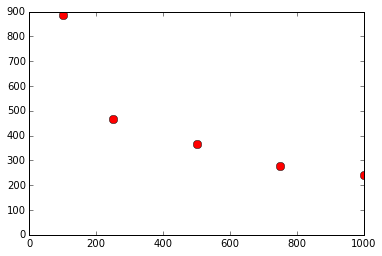

In [34]:
stdErr = dict()

for k in [100, 250, 500, 750, 1000]:

    with open("data/SE-NC_full-N=" + str(k) + ".json", "r") as fd:
        results = json.load(fd)
        
    stdErr[k] = np.std(results)
    
plt.plot(stdErr.keys(), stdErr.values(), 'o-', color='r', linestyle='None', markersize=8)
plt.xlim(xmin=0)
plt.ylim(ymin=0)
plt.show()

In [35]:
y = [math.log(i) for i in stdErr.values()]
x = [math.log(i) for i in stdErr.keys()]
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)

print 'lambda = %f' % (-slope)
print 'alpha = %f' % (math.exp(intercept))

lambda = 0.551575
alpha = 10774.771915


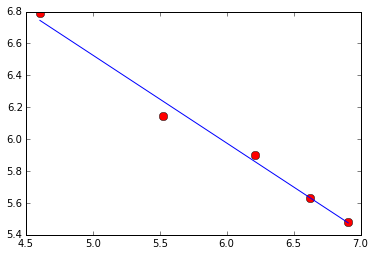

In [36]:
keys = [math.log(i) for i in stdErr.keys()]
keys.sort()
solution = [intercept + slope*n for n in keys]

plt.plot(x, [math.log(i) for i in stdErr.values()], 'o-', color='r', linestyle='None', markersize=8)
plt.plot(keys, solution)
# plt.xlim(xmin=4)
# plt.ylim(ymin=-1)
plt.show()